In [185]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

## Beachte Konvention: Zeit in Stunden und Winkel in Grad

### Observed Zenith angle

In [186]:
time_top = np.array([11+42/60+47/3600, 11+44/60+8/3600, 11+56/60+50/3600, 11+57/60+37/3600, 12+4/60+53/3600, 12+6/60+3/3600,
                     11+43/60+31/3600, 11+45/60+5/3600, 11+46/60+20/3600, 11+47/60+22/3600, 11+51/60+27/3600]) - 2 # in h, UT
z_b_top = np.array([39+9/60+32/3600, 39+3/60+16/3600, 38+6/60+6/3600, 38+3/60+7/3600, 37+35/60+57/3600, 37+32/60+2/3600,
                    38+49/60+19/3600, 38+56/60+10/3600, 38+36/60+37/3600, 38+48/60+14/3600, 38+30/60+23/3600]) # deg

time_bottom = np.array([11+49/60+8/3600, 11+51/60+3/3600,11+59/60+29/3600, 12+1/60+11/3600,
                        11+23/60+16/3600, 11+24/60+5/3600, 11+31/60+13/3600, 11+32/60+56/3600, 11+36/60+24/3600, 11+38/60+9/3600, 11+42/60+17/3600]) - 2 # in h, UT
z_b_bottom = np.array([39+12/60+26/3600, 39+4/60+52/3600, 38+29/60+1/3600, 38+21/60+33/3600,
                       41+23/60+11/3600, 41+18/60+13/3600, 40+39/60+18/3600, 40+46/60+52/3600, 40+12/60+43/3600,  39+46/60+56/3600,39+41/60+56/3600]) # deg

### Almanac

In [187]:
GMST_0UT = 14 + 52/60 + 28.7584/3600 # in h
alpha_5 = 2.8197997 # in h
alpha_6 = 2.8841898 # in h
delta_5 = 16.262748 # in deg
delta_6 = 16.545533 # in deg
phi_1 = 15/60 + 51.58/3600 # in deg
phi_2 = 8.72/3600 # in deg

l = 13 + 17/60 + 42.5/3600 # in deg

### Corrections

#### Index error

In [188]:
z_0 = np.array([85+35/60+37/3600, 85+35/60+59/3600, 85+35/60+26/3600, 85+35/60+28/3600]) # in deg
z_180 = np.array([274+23/60+44/3600, 274+23/60+53/3600, 274+23/60+24/3600, 274+22/60+41/3600]) # in deg
i = np.mean((360 - (z_0 + z_180))/2) # in deg
i


0.007916666666659467

#### Refraction

In [189]:
# z_b is in '' but we want °
R_mean_top = 1/np.tan(((90-z_b_top) + (7.31)/ (90-z_b_top+4.4)) * np.pi/180) # removed the 3600 since it is already in deg
R_mean_bottom = 1/np.tan(((90-z_b_bottom) + (7.31)/ (90-z_b_bottom+4.4)) * np.pi/180)
# the unit shouldbe arcminutes according to wikipedia

P_mean = 0.5*(101.83 + 101.80 ) # kPa
T_mean = 0.5*(11 + 13) #°C

R_top = R_mean_top *(P_mean/101 * 283/(273+T_mean))
R_bottom = R_mean_bottom *(P_mean/101 * 283/(273+T_mean))

# convert R from arcminutes to deg
R_top = R_top/60
R_bottom = R_bottom/60

#### Transform to center of solar disk

In [190]:
z_top = z_b_top + i + R_top + phi_1 - phi_2
z_bottom = z_b_bottom + i + R_bottom - phi_1 - phi_2

In [191]:
z = np.concatenate((z_top, z_bottom)) # in deg
time = np.concatenate((time_top, time_bottom)) # in h

### Interpolation alpha

In [192]:
alpha = alpha_5 + time/24 * (alpha_6 - alpha_5) # in h

### Interpolation delta

In [193]:
delta = delta_5 + time/24 * (delta_6 - delta_5) # in deg

### Hour Angle in arcsec

In [194]:
tau = GMST_0UT + time * (366.24/365.24) + l/15 - alpha # alles in h

In [195]:
Y = np.arctan(np.cos(tau*15*np.pi/180) / np.tan(delta * np.pi/180)) # rad
X = np.sin(delta*np.pi/180) * np.sqrt(1 + (np.cos(tau*15*np.pi/180)/ np.tan(delta*np.pi/180))**2)

### Prüfe welche Gleichung

In [196]:
b = (52 + 27/60 + 24/3600)*np.pi/180 # rad
print((Y + b) > np.pi/2)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


-> First solution for b!

In [197]:
b = (np.pi - np.arcsin(np.cos(z*np.pi/180)/X) - Y) * 180/np.pi
bmean = np.mean(b)
degrees = int(bmean)
minutes = int((bmean - int(bmean))*60)
seconds = int(((bmean - int(bmean))*60 - minutes)*60)

print(bmean)
print(degrees)
print(minutes)
print(seconds)

52.42787173588032
52
25
40


In [204]:
b.shape

(22,)

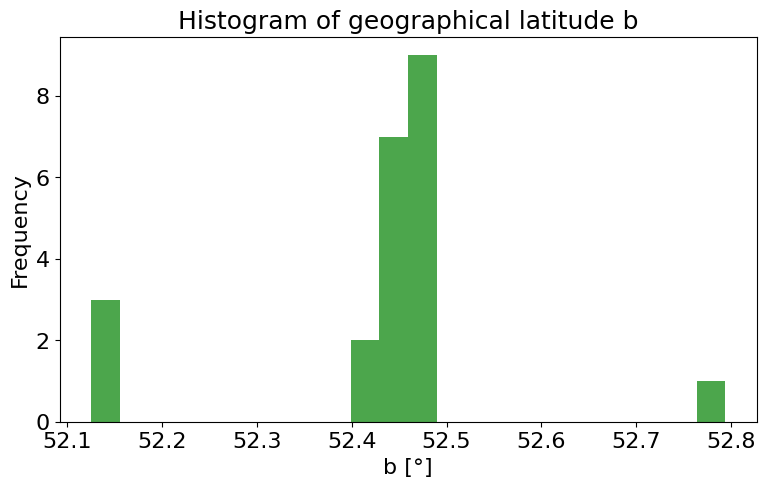

In [213]:
plt.figure(figsize=(9, 5))
plt.hist(b, bins=22, alpha=0.7, color='green')
plt.title('Histogram of geographical latitude b', fontsize=18)
plt.xlabel('b [°]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16)  
plt.savefig('histogram.png', dpi=300, bbox_inches='tight')

In [149]:
# Breitengrad laut Google maps: 52°27'24''

In [150]:
check = degrees + minutes/60 + seconds/3600
check

52.42777777777778

# Error propagation

In [151]:
# errors
s_a_time = 1/3600 # Ablesefehler digitale Anzeige (Atomuhr): +- letzte Stelle, Restfehler von atomic clock unbekannt
s_a_zb = 1/3600 # Ablesefehler zenith angle
s_r_zb = 5/3600 # Restfehler laut Hersteller = 5''

u_zb = np.sqrt(s_a_zb**2 + s_r_zb**2) # Ablese und Restfehler kombinieren
u_time = s_a_time

In [152]:
s_a_z = 1/3600 # Ablesefehler zenith angle
s_i = 0.5*np.sqrt(2)*s_a_zb

In [153]:
# Calculate error for Refraction via error propagation
a = sp.symbols('a')  # Changed z to a
R_mean = sp.cot(((90 - a) + (7.31) / (90 - a + 4.4)) * sp.pi / 180)  # formula for Rmean
par_der = sp.diff(R_mean, a)  # partial derivative
par_der_results_top = np.zeros(z_b_top.shape[0])
par_der_results_bottom = np.zeros(z_b_bottom.shape[0])

for i in range(z_b_bottom.shape[0]):
    par_der_results_bottom[i] = par_der.subs({a: z_b_bottom[i]}).evalf()  # Changed z to a

for i in range(z_b_top.shape[0]):
    par_der_results_top[i] = par_der.subs({a: z_b_top[i]}).evalf()  # Changed z to a

# error for Rmean
s_Rmean_top = np.abs(par_der_results_top) * np.abs(u_zb)
s_Rmean_bottom = np.abs(par_der_results_bottom) * np.abs(u_zb)

# error for R
s_R_top = np.abs(P_mean / 101 * 283 / (273 + T_mean)) * np.abs(s_Rmean_top) / 60
s_R_bottom = np.abs(P_mean / 101 * 283 / (273 + T_mean)) * np.abs(s_Rmean_bottom) / 60


In [154]:
s_z_top = np.abs(u_zb) + np.abs(s_i)+ np.abs(s_R_top)
s_z_bottom = np.abs(u_zb) + np.abs(s_i)+ np.abs(s_R_bottom)
s_z = np.concatenate((s_z_top, s_z_bottom))
s_alpha = np.abs((alpha_6 - alpha_5)/24 * u_time)
s_delta = np.abs((delta_6 - delta_5)/24 * u_time)
s_tau = u_time * (366.24/365.24)

In [155]:
t, d = sp.symbols('t d')

y = sp.atan(sp.cos(t * 15 * sp.pi / 180) / sp.tan(d * sp.pi / 180))
x = sp.sin(d * sp.pi / 180) * sp.sqrt(1 + (sp.cos(t * 15 * sp.pi / 180) / sp.tan(d * sp.pi / 180))**2)

dy_dt = sp.diff(y, t)
dx_dt = sp.diff(x, t)

t_values = tau
d_value = delta

dy_results = np.zeros(tau.shape[0])
dx_results = np.zeros(tau.shape[0])

for i in range(len(t_values)):
    dy_results[i] = dy_dt.subs({t: t_values[i] * np.pi / 180, d: d_value[i] * np.pi / 180}).evalf()
    dx_results[i] = dx_dt.subs({t: t_values[i] * np.pi / 180, d: d_value[i] * np.pi / 180}).evalf()

s_x = np.abs(dx_results) * s_tau
s_y = np.abs(dy_results) * s_tau
s_x


array([7.53481864e-06, 7.54227559e-06, 7.61242225e-06, 7.61674865e-06,
       7.65688161e-06, 7.66332475e-06, 7.53886934e-06, 7.54752302e-06,
       7.55442748e-06, 7.56013512e-06, 7.58268903e-06, 7.56989323e-06,
       7.58047970e-06, 7.62705826e-06, 7.63644723e-06, 7.42700620e-06,
       7.43151789e-06, 7.47092496e-06, 7.48040810e-06, 7.49955815e-06,
       7.50922504e-06, 7.53205678e-06])

In [156]:
x, y, zet = sp.symbols('x y zet')

b = (sp.pi - sp.asin(sp.cos(zet * sp.pi / 180) / x) - y) * 180 / sp.pi

db_dX = sp.diff(b, x)
db_dY = sp.diff(b, y)
db_dz = sp.diff(b, zet)

dx_results = np.zeros(z.shape[0])
dy_results = np.zeros(z.shape[0])
dz_results = np.zeros(z.shape[0])

for i in range(z.shape[0]):
    dx_results[i] = db_dX.subs({x: X[i], y: Y[i], zet: z[i]}).evalf()
    dy_results[i] = db_dX.subs({x: X[i], y: Y[i], zet: z[i]}).evalf()
    dz_results[i] = db_dX.subs({x: X[i], y: Y[i], zet: z[i]}).evalf()

s_b = np.sqrt(dx_results**2 * s_x**2 + dy_results**2 * s_y**2 + dz_results**2 * s_z**2)
s_b_mean = np.sum(s_b**2)/s_b.shape[0]
degrees = int(s_b_mean)
minutes = int((s_b_mean - int(s_b_mean))*60)
seconds = int(((s_b_mean - int(s_b_mean))*60 - minutes)*60)
print(degrees)
print(minutes)
print(seconds)


0
1
9
